In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [8]:
DF = pd.read_csv('finalData.csv').drop(['Unnamed: 0.1'],axis=1).drop(['Unnamed: 0'],axis=1).drop(['Year'],axis=1).drop(['City'],axis=1).drop(['State'],axis=1)
DF=DF.rename(columns = {'Vehicle Type':'vehicleType'})

In [9]:
DF = DF.join(pd.get_dummies(DF.vehicleType))
DF = DF.drop(['vehicleType'], axis = 1)
DF.head(20)

,Mileage,serviceTime,DepreciationRate,Gdp,Population,SUV,Sedan,Truck
0,52080,7,0.421956,49853,1417,0,1,0
1,38893,2,0.560101,3937,14910,1,0,0
2,20103,3,0.861051,344881,13212,1,0,0
3,48885,8,0.364226,38874,23714,1,0,0
4,42177,5,0.483548,24395,12064,1,0,0
5,35497,6,0.678010,28937,331,0,0,1
6,9109,3,0.942408,192177,2031,0,0,1
7,64947,4,0.858639,192177,4881,0,0,1
8,42092,4,0.832435,13820,4065,0,0,1
9,92503,8,0.328423,41459,7181,1,0,0


In [12]:
currentRegression = []
IndeVari = list(DF.columns)
IndeVari.remove('DepreciationRate')

bestAllTimeBic = np.inf
    
while True:
    currentBestBic = np.inf
    toAdd = None
    for vari in IndeVari:
        regTemp = currentRegression[:]
        regTemp.extend([vari])
        currentLm = sm.OLS(DF.DepreciationRate, sm.add_constant(DF[regTemp])).fit()
        currentBic = currentLm.bic
        print ("BIC after adding " + vari + ": "+ str(currentBic))
        if currentBic < currentBestBic:
            toAdd = vari
            currentBestBic = currentBic
    if currentBestBic < bestAllTimeBic:
        print ("Adding " + toAdd + " to model.")
        currentRegression.append(toAdd)        
        print('The independent variables: '+ str(currentRegression))
        IndeVari.remove(toAdd)
        bestAllTimeBic = currentBestBic
    else:
        print ("Get the best (minimum) BIC. Ending forward selection.")
        print()
        print('The final independent variables: '+ str(currentRegression))
        break

BIC after adding Mileage: -1124.5382079648646
BIC after adding serviceTime: -1268.3655171919393
BIC after adding Gdp: -544.4160052619683
BIC after adding Population: -538.625286966425
BIC after adding SUV: -542.0225318647
BIC after adding Sedan: -750.895246566729
BIC after adding Truck: -701.1830801126617
Adding serviceTime to model.
The independent variables: ['serviceTime']
BIC after adding Mileage: -1294.188956817241
BIC after adding Gdp: -1267.7880488014134
BIC after adding Population: -1263.87453873104
BIC after adding SUV: -1263.327274884532
BIC after adding Sedan: -1895.88799476664
BIC after adding Truck: -1820.3666066043525
Adding Sedan to model.
The independent variables: ['serviceTime', 'Sedan']
BIC after adding Mileage: -2024.757208572775
BIC after adding Gdp: -1888.63266985944
BIC after adding Population: -1888.7864015745342
BIC after adding SUV: -2048.65617512499
BIC after adding Truck: -2048.65617512499
Adding SUV to model.
The independent variables: ['serviceTime', 'Seda

In [13]:
lm = smf.ols('DepreciationRate ~ serviceTime+Sedan+SUV+Mileage+Truck', data=DF).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       DepreciationRate   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     701.6
Date:                Wed, 05 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:21:27   Log-Likelihood:                 1114.7
No. Observations:                1746   AIC:                            -2219.
Df Residuals:                    1741   BIC:                            -2192.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6276      0.004    147.674      

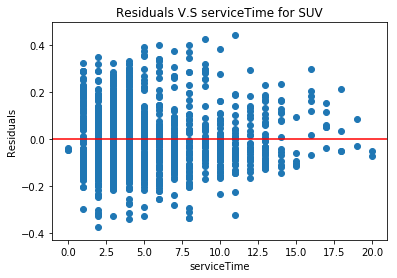

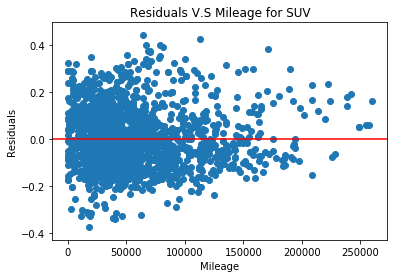

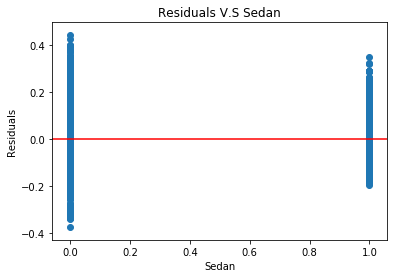

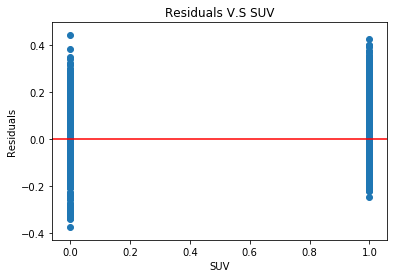

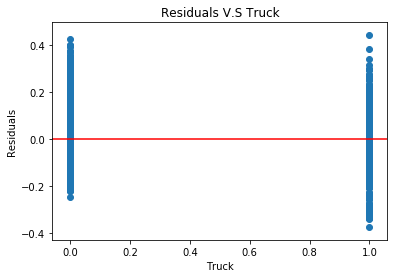

In [15]:
DF['Prediction'] = lm.predict()
plt.scatter(DF.serviceTime, DF.DepreciationRate-DF.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for SUV')
plt.show()
plt.scatter(DF.Mileage, DF.DepreciationRate-DF.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for SUV')
plt.show()
plt.scatter(DF.Sedan, DF.DepreciationRate-DF.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Sedan')
plt.ylabel('Residuals')
plt.title('Residuals V.S Sedan')
plt.show()
plt.scatter(DF.SUV, DF.DepreciationRate-DF.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('SUV')
plt.ylabel('Residuals')
plt.title('Residuals V.S SUV')
plt.show()
plt.scatter(DF.Truck, DF.DepreciationRate-DF.Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Truck')
plt.ylabel('Residuals')
plt.title('Residuals V.S Truck')
plt.show()